<a href="https://colab.research.google.com/github/JiHoonPark96/practice/blob/main/econometrics_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy statsmodels patsy


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [3]:
# Upload ecls_k5.csv to Colab first
df = pd.read_csv("ecls_k5.csv")
df.head()


,region,gender,race,bmi,mom_educ,mom_married_at_birth,family_income,mom_work_status,siblings,hhsize,...,problem_weapons,problem_attacks,has_library_card,has_home_computer,school_has_security,reading_test,math_test,science_test,mom_curr_married,family_type
0,1,2,1,18.18,3,1,120000.0,2,0,3,...,0,0,0,1,0,115.627940,110.004630,112.372620,1,2
1,1,1,1,15.88,5,1,55000.0,1,1,4,...,0,0,0,1,0,103.764820,91.927467,95.199417,1,1
2,1,2,1,16.80,5,1,70000.0,1,1,4,...,0,0,0,1,0,104.080860,105.238530,104.478130,1,1
3,1,2,1,21.47,5,1,50000.0,1,1,4,...,0,0,0,1,0,103.666880,106.177150,105.422580,1,1
4,1,2,1,24.76,3,1,50000.0,2,2,5,...,0,0,0,1,0,96.081596,79.131935,96.237595,1,1


In [4]:
df2 = df.copy()

# -----------------------------
# Maternal education dummies
# Baseline: mom_educ <= 2
# -----------------------------
df2["mom_medium_3"] = (df2["mom_educ"] == 3).astype(int)
df2["mom_medium_4"] = (df2["mom_educ"] == 4).astype(int)
df2["mom_high"]     = (df2["mom_educ"] == 5).astype(int)

# -----------------------------
# Gender
# Baseline: female
# -----------------------------
df2["male"] = (df2["gender"] == 1).astype(int)

# -----------------------------
# Race (baseline: White)
# -----------------------------
df2["race_black"]    = (df2["race"] == 2).astype(int)
df2["race_hispanic"] = (df2["race"] == 3).astype(int)
df2["race_other"]    = (df2["race"] == 4).astype(int)

# -----------------------------
# School type (baseline: public)
# -----------------------------
df2["school_catholic"] = (df2["school_type"] == 2).astype(int)
df2["school_private"]  = (df2["school_type"] == 3).astype(int)

# -----------------------------
# Minority composition (baseline: <10%)
# -----------------------------
df2["pct_min_10_25"] = (df2["pct_minority"] == 2).astype(int)
df2["pct_min_25_50"] = (df2["pct_minority"] == 3).astype(int)
df2["pct_min_50_75"] = (df2["pct_minority"] == 4).astype(int)
df2["pct_min_gt_75"] = (df2["pct_minority"] == 5).astype(int)

# -----------------------------
# Log family income
# -----------------------------
df2["log_family_income"] = np.where(df2["family_income"] > 0,
                                    np.log(df2["family_income"]),
                                    np.nan)


In [5]:
all_vars = [
    "math_test", "male", "race_black", "race_hispanic", "race_other",
    "mom_medium_3", "mom_medium_4", "mom_high",
    "log_family_income", "hhsize", "both_parents", "mom_married_at_birth",
    "tv_afternoon_mf", "tv_afterdinner_mf", "tv_saturday", "tv_sunday",
    "dinner_as_family", "home_language_nonenglish", "mom_work_status",
    "has_library_card", "has_home_computer",
    "school_catholic", "school_private",
    "pct_min_10_25", "pct_min_25_50", "pct_min_50_75", "pct_min_gt_75",
    "school_has_security", "problem_crowding", "problem_turnover",
    "problem_parents", "problem_drugs", "problem_gangs", "problem_crime",
    "problem_weapons", "problem_attacks"
]

df_final = df2.dropna(subset=all_vars)


In [6]:
base_vars = [
    "mom_medium_3", "mom_medium_4", "mom_high",
    "male", "race_black", "race_hispanic", "race_other"
]

family_back = [
    "log_family_income", "hhsize", "both_parents", "mom_married_at_birth"
]

family_env = [
    "tv_afternoon_mf", "tv_afterdinner_mf", "tv_saturday", "tv_sunday",
    "dinner_as_family", "home_language_nonenglish", "mom_work_status",
    "has_library_card", "has_home_computer"
]

school_env = [
    "school_catholic", "school_private",
    "pct_min_10_25", "pct_min_25_50", "pct_min_50_75", "pct_min_gt_75",
    "school_has_security", "problem_crowding", "problem_turnover",
    "problem_parents", "problem_drugs", "problem_gangs", "problem_crime",
    "problem_weapons", "problem_attacks"
]


In [7]:
def run_ols(formula, data):
    y, X = dmatrices(formula, data=data, return_type="dataframe")
    return sm.OLS(y, X).fit()


In [8]:
f1 = "math_test ~ " + " + ".join(base_vars)
f2 = "math_test ~ " + " + ".join(base_vars + family_back)
f3 = "math_test ~ " + " + ".join(base_vars + family_back + family_env)
f4 = "math_test ~ " + " + ".join(base_vars + family_back + family_env + school_env)

f5 = (
    "math_test ~ male + race_black + race_hispanic + race_other + "
    "home_language_nonenglish * (mom_medium_3 + mom_medium_4 + mom_high) + " +
    " + ".join(family_back + [v for v in family_env if v != "home_language_nonenglish"] + school_env)
)

m1 = run_ols(f1, df_final)
m2 = run_ols(f2, df_final)
m3 = run_ols(f3, df_final)
m4 = run_ols(f4, df_final)
m5 = run_ols(f5, df_final)


In [9]:
bp_test = het_breuschpagan(m4.resid, m4.model.exog)
labels = ["LM stat", "LM p-value", "F stat", "F p-value"]
dict(zip(labels, bp_test))


{'LM stat': np.float64(293.08686897580907),
 'LM p-value': np.float64(1.6377607288314752e-42),
 'F stat': np.float64(8.649492516294597),
 'F p-value': np.float64(2.0175925969242497e-43)}

In [10]:
def robust_se(model):
    return model.get_robustcov_results(cov_type="HC3")


In [11]:
m1r, m2r, m3r, m4r, m5r = map(robust_se, [m1, m2, m3, m4, m5])


In [12]:
def wald_test(model, vars_list):
    R = np.zeros((len(vars_list), len(model.params)))
    for i, v in enumerate(vars_list):
        R[i, model.params.index.get_loc(v)] = 1
    return model.wald_test(R)


In [18]:
def wald_test(model, vars_list):
    # Use model.model.exog_names to get parameter names, which is more robust
    param_names = model.model.exog_names
    R = np.zeros((len(vars_list), len(model.params)))

    # Create a mapping from name to position for easier lookup
    name_to_pos = {name: i for i, name in enumerate(param_names)}

    for i, v in enumerate(vars_list):
        # Ensure the variable exists in the model's parameters before trying to get its location
        if v in name_to_pos:
            R[i, name_to_pos[v]] = 1
        else:
            # This case should ideally not happen if vars_list contains valid parameter names
            # from the model, including interaction terms generated by patsy.
            # If it does, it indicates an issue with the vars_list or formula.
            print(f"Warning: Variable '{v}' not found in model parameters. Skipping selection for this variable.")

    return model.wald_test(R)

wald_results = pd.DataFrame({
    "Model": [
        "Baseline (m1)", "Add Family Background (m2)",
        "Add Family Environment (m3)", "Add School Environment (m4)",
        "Interaction Effects (m5)"
    ],
    "F_stat": [
        wald_test(m1r, base_vars).statistic[0][0],
        wald_test(m2r, family_back).statistic[0][0],
        wald_test(m3r, family_env).statistic[0][0],
        wald_test(m4r, school_env).statistic[0][0],
        wald_test(m5r, [
            "home_language_nonenglish:mom_medium_3",
            "home_language_nonenglish:mom_medium_4",
            "home_language_nonenglish:mom_high"
        ]).statistic[0][0]
    ],
    "p_value": [
        wald_test(m1r, base_vars).pvalue,
        wald_test(m2r, family_back).pvalue,
        wald_test(m3r, family_env).pvalue,
        wald_test(m4r, school_env).pvalue,
        wald_test(m5r, [
            "home_language_nonenglish:mom_medium_3",
            "home_language_nonenglish:mom_medium_4",
            "home_language_nonenglish:mom_high"
        ]).pvalue
    ]
})

wald_results

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


,Model,F_stat,p_value
0,Baseline (m1),315.615579,0.0
1,Add Family Background (m2),50.053890,1.114549972522061e-41
2,Add Family Environment (m3),11.581845,2.91577648003285e-18
3,Add School Environment (m4),6.395527,9.466385685419844e-14
4,Interaction Effects (m5),4.103272,0.006419489736212707


In [25]:
def overall_wald(model):
    # Use model.model.exog_names to get parameter names, which is more robust
    vars_all = [v for v in model.model.exog_names if v != "Intercept"]
    return wald_test(model, vars_all)

overall = pd.DataFrame({
    "Model": ["m1", "m2", "m3", "m4", "m5"],
    "F_stat": [overall_wald(m).statistic[0][0] for m in [m1r, m2r, m3r, m4r, m5r]],
    "p_value": [overall_wald(m).pvalue for m in [m1r, m2r, m3r, m4r, m5r]]
})

overall

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


,Model,F_stat,p_value
0,m1,315.615579,0.0
1,m2,219.952882,0.0
2,m3,128.728251,0.0
3,m4,77.142067,0.0
4,m5,71.453745,0.0


## Summary of Results

Below are the key statistical results from the regression analysis performed:

1.  **Breusch-Pagan Test for Heteroskedasticity**: This test assesses whether the variance of the errors in a regression model is constant across all levels of the independent variables. A significant p-value (typically less than 0.05) indicates the presence of heteroskedasticity, suggesting that the standard OLS assumptions are violated and robust standard errors should be used.

2.  **Wald Tests for Variable Groups**: These tests evaluate the joint significance of groups of independent variables. A significant p-value indicates that the variables in that group, as a whole, contribute significantly to explaining the variation in the dependent variable.

3.  **Overall Wald Tests for Each Model**: These tests assess the overall significance of each regression model, indicating whether the entire set of independent variables in a model collectively explains a significant portion of the variance in the dependent variable.

In [26]:
print("\n--- Breusch-Pagan Test Results (for model m4) ---")
print(dict(zip(labels, bp_test)))

print("\n--- Wald Tests for Individual Variable Groups ---")
display(wald_results)

print("\n--- Overall Wald Tests for Each Model ---")
display(overall)


--- Breusch-Pagan Test Results (for model m4) ---
{'LM stat': np.float64(293.08686897580907), 'LM p-value': np.float64(1.6377607288314752e-42), 'F stat': np.float64(8.649492516294597), 'F p-value': np.float64(2.0175925969242497e-43)}

--- Wald Tests for Individual Variable Groups ---


,Model,F_stat,p_value
0,Baseline (m1),315.615579,0.0
1,Add Family Background (m2),50.053890,1.114549972522061e-41
2,Add Family Environment (m3),11.581845,2.91577648003285e-18
3,Add School Environment (m4),6.395527,9.466385685419844e-14
4,Interaction Effects (m5),4.103272,0.006419489736212707



--- Overall Wald Tests for Each Model ---


,Model,F_stat,p_value
0,m1,315.615579,0.0
1,m2,219.952882,0.0
2,m3,128.728251,0.0
3,m4,77.142067,0.0
4,m5,71.453745,0.0


In [23]:
# Robustness: alternative dependent variables
# Same RHS specification as Model 5

rhs_full = """
mom_medium_3 + mom_medium_4 + mom_high +
home_language_nonenglish +
home_language_nonenglish:mom_medium_3 +
home_language_nonenglish:mom_medium_4 +
home_language_nonenglish:mom_high +
male + race_black + race_hispanic + race_other +
log_family_income + hhsize + both_parents + mom_married_at_birth +
tv_afternoon_mf + tv_afterdinner_mf + tv_saturday + tv_sunday +
dinner_as_family + mom_work_status +
has_library_card + has_home_computer +
school_catholic + school_private +
pct_min_10_25 + pct_min_25_50 + pct_min_50_75 + pct_min_gt_75 +
school_has_security +
problem_crowding + problem_turnover + problem_parents +
problem_drugs + problem_gangs + problem_crime +
problem_weapons + problem_attacks
"""

robust_models = {}

for dv in ["math_test", "reading_test", "science_test"]:
    formula = f"{dv} ~ {rhs_full}"
    model = run_ols(formula, df_final)
    robust_models[dv] = model
    print(f"\n=== Dependent Variable: {dv} ===")
    print(model.get_robustcov_results(cov_type='HC3').summary().tables[0])



=== Dependent Variable: math_test ===
                            OLS Regression Results                            
Dep. Variable:              math_test   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     71.45
Date:                Thu, 18 Dec 2025   Prob (F-statistic):               0.00
Time:                        05:22:37   Log-Likelihood:                -28919.
No. Observations:                8105   AIC:                         5.792e+04
Df Residuals:                    8066   BIC:                         5.819e+04
Df Model:                          38                                         
Covariance Type:                  HC3                                         

=== Dependent Variable: reading_test ===
                            OLS Regression Results                            
Dep. Variable:           reading_test   R-squared:

In [27]:
# Compute marginal effects of maternal education
# by home language status

import pandas as pd
import numpy as np

interaction_vars = [
    "mom_medium_3",
    "mom_medium_4",
    "mom_high"
]

results = []

# Get parameter names from the model and create a mapping for robust access
param_names = m5r.model.exog_names
name_to_pos = {name: i for i, name in enumerate(param_names)}

for edu in interaction_vars:
    # Get coefficient for main effect
    main_effect_name = edu
    coef_main = m5r.params[name_to_pos[main_effect_name]]

    # Get coefficient for interaction effect
    interaction_effect_name = f"home_language_nonenglish:{edu}"
    coef_inter = m5r.params[name_to_pos[interaction_effect_name]]

    effect_english = coef_main
    effect_non_english = coef_main + coef_inter

    results.append({
        "Education Level": edu,
        "Effect (English home)": effect_english,
        "Effect (Non-English home)": effect_non_english
    })

interaction_effects = pd.DataFrame(results)
interaction_effects

,Education Level,Effect (English home),Effect (Non-English home)
0,mom_medium_3,3.961210,1.287293
1,mom_medium_4,5.865777,2.666626
2,mom_high,8.451584,6.088791


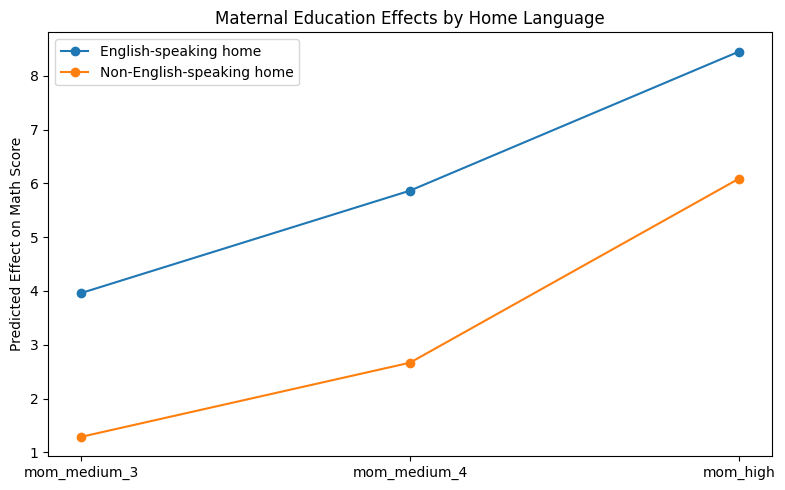

In [28]:
import matplotlib.pyplot as plt

labels = interaction_effects["Education Level"]
x = range(len(labels))

plt.figure(figsize=(8,5))
plt.plot(x, interaction_effects["Effect (English home)"], marker="o", label="English-speaking home")
plt.plot(x, interaction_effects["Effect (Non-English home)"], marker="o", label="Non-English-speaking home")

plt.xticks(x, labels)
plt.ylabel("Predicted Effect on Math Score")
plt.title("Maternal Education Effects by Home Language")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
# Reduced school environment specification
school_env_reduced = [
    "school_catholic", "school_private",
    "pct_min_50_75", "pct_min_gt_75",
    "problem_gangs", "problem_crime"
]

formula_reduced = (
    "math_test ~ mom_medium_3 + mom_medium_4 + mom_high + "
    "home_language_nonenglish + "
    "home_language_nonenglish:mom_medium_3 + "
    "home_language_nonenglish:mom_medium_4 + "
    "home_language_nonenglish:mom_high + "
    "male + race_black + race_hispanic + race_other + "
    "log_family_income + hhsize + both_parents + mom_married_at_birth + " +
    " + ".join(family_env) + " + " +
    " + ".join(school_env_reduced)
)

m5_reduced = run_ols(formula_reduced, df_final)
m5_reduced.get_robustcov_results(cov_type="HC3").summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              math_test   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     90.83
Date:                Thu, 18 Dec 2025   Prob (F-statistic):               0.00
Time:                        05:23:49   Log-Likelihood:                -28945.
No. Observations:                8105   AIC:                         5.795e+04
Df Residuals:                    8075   BIC:                         5.816e+04
Df Model:                          29                                         
Covariance Type:                  HC3                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                81.0228      1.750     46.309      0.000      77.593      84.452
mom_medium_3                              3.8985      0.562      6.937      0.000       2.797       5.000
mom_medium_4                              5.8564      0.571     10.250      0.000       4.736       6.976
mom_high                                  8.5065      0.592     14.359      0.000       7.345       9.668
home_language_nonenglish                  2.7392      0.745      3.678      0.000       1.279       4.199
home_language_nonenglish:mom_medium_3    -2.5411      0.885     -2.871      0.004      -4.276      -0.806
home_language_nonenglish:mom_medium_4    -3.1786      1.038     -3.061      0.002      -5.214      -1.143
home_language_nonenglish:mom_high        -2.1905      0.953     -2.299      0.022      -4.058      -0.323
male                                      2.1231      0.193     11.010      0.000       1.745       2.501
race_black                               -4.1953      0.443     -9.466      0.000      -5.064      -3.326
race_hispanic                            -1.2570      0.364     -3.457      0.001      -1.970      -0.544
race_other                                0.8209      0.360      2.277      0.023       0.114       1.528
log_family_income                         1.0571      0.157      6.722      0.000       0.749       1.365
hhsize                                   -0.4012      0.082     -4.886      0.000      -0.562      -0.240
both_parents                              0.4301      0.297      1.451      0.147      -0.151       1.011
mom_married_at_birth                      1.8489      0.299      6.185      0.000       1.263       2.435
tv_afternoon_mf                          -0.3497      0.137     -2.559      0.011      -0.618      -0.082
tv_afterdinner_mf                        -0.1405      0.131     -1.072      0.284      -0.397       0.116
tv_saturday                               0.2571      0.089      2.886      0.004       0.082       0.432
tv_sunday                                -0.1796      0.086     -2.079      0.038      -0.349      -0.010
dinner_as_family                         -0.1121      0.054     -2.063      0.039      -0.219      -0.006
mom_work_status                           0.3034      0.123      2.464      0.014       0.062       0.545
has_library_card                         -0.8331      0.317     -2.632      0.009      -1.454      -0.213
has_home_computer                         3.0275      0.381      7.955      0.000       2.282       3.774
school_catholic                          -1.0349      0.258     -4.007      0.000      -1.541      -0.529
school_private                            0.4198      0.336      1.250      0.211      -0.239       1.078
pct_min_5

In [33]:
# Key variables we want to interpret in the paper
key_vars = [
    "mom_medium_3", "mom_medium_4", "mom_high",
    "home_language_nonenglish",
    "home_language_nonenglish:mom_medium_3",
    "home_language_nonenglish:mom_medium_4",
    "home_language_nonenglish:mom_high",
    "male",
    "log_family_income"
]

def extract_results(model, model_name):
    res = model.get_robustcov_results(cov_type="HC3")
    rows = []

    # Get parameter names from the model's exogenous variables
    param_names = res.model.exog_names
    # Create a mapping from name to position for easier lookup
    name_to_pos = {name: i for i, name in enumerate(param_names)}

    for v in key_vars:
        if v in name_to_pos: # Check if the variable exists in the model
            idx = name_to_pos[v]
            rows.append({
                "Model": model_name,
                "Variable": v,
                "Coef": res.params[idx],
                "Robust_SE": res.bse[idx],
                "p_value": res.pvalues[idx]
            })
        # else: Variable not in this model, skip it
    return pd.DataFrame(rows)

results_table = pd.concat([
    extract_results(m1, "M1"),
    extract_results(m2, "M2"),
    extract_results(m3, "M3"),
    extract_results(m4, "M4"),
    extract_results(m5, "M5")
])

results_table

,Model,Variable,Coef,Robust_SE,p_value
0,M1,mom_medium_3,4.382503,0.418956,1.903904e-25
1,M1,mom_medium_4,7.096769,0.424730,1.207525e-61
2,M1,mom_high,10.855189,0.425240,2.603006e-138
3,M1,male,2.095670,0.196891,2.779358e-26
0,M2,mom_medium_3,3.245524,0.423460,2.006591e-14
1,M2,mom_medium_4,5.398141,0.439432,2.222298e-34
2,M2,mom_high,8.241430,0.464889,5.110620e-69
3,M2,male,2.075326,0.193828,1.419771e-26
4,M2,log_family_income,1.262827,0.162681,9.336170e-15
0,M3,mom_medium_3,2.870913,0.433043,3.581346e-11


In [34]:
pivot_table = results_table.pivot(
    index="Variable",
    columns="Model",
    values="Coef"
)

pivot_table


Model,M1,M2,M3,M4,M5
Variable,,,,,
home_language_nonenglish,NaN,NaN,0.547481,0.773440,2.759532
home_language_nonenglish:mom_high,NaN,NaN,NaN,NaN,-2.362793
home_language_nonenglish:mom_medium_3,NaN,NaN,NaN,NaN,-2.673917
home_language_nonenglish:mom_medium_4,NaN,NaN,NaN,NaN,-3.199151
log_family_income,NaN,1.262827,1.115707,1.022235,1.006194
male,2.095670,2.075326,2.144224,2.110967,2.105034
mom_high,10.855189,8.241430,7.526772,7.383529,8.451584
mom_medium_3,4.382503,3.245524,2.870913,2.854809,3.961210
mom_medium_4,7.096769,5.398141,4.813422,4.770845,5.865777


In [35]:
wald_results


,Model,F_stat,p_value
0,Baseline (m1),315.615579,0.0
1,Add Family Background (m2),50.053890,1.114549972522061e-41
2,Add Family Environment (m3),11.581845,2.91577648003285e-18
3,Add School Environment (m4),6.395527,9.466385685419844e-14
4,Interaction Effects (m5),4.103272,0.006419489736212707


In [36]:
summary_sentences = []

# Education effects
edu_effect = results_table[
    (results_table["Model"] == "M5") &
    (results_table["Variable"] == "mom_high")
].iloc[0]

summary_sentences.append(
    f"In the fully specified model, children whose mothers completed college score "
    f"{edu_effect['Coef']:.2f} points higher on math tests compared to those whose mothers "
    f"have at most a middle school education (p = {edu_effect['p_value']:.3f})."
)

# Interaction effect
inter = results_table[
    (results_table["Model"] == "M5") &
    (results_table["Variable"] == "home_language_nonenglish:mom_high")
].iloc[0]

summary_sentences.append(
    f"The positive association between maternal college education and math achievement "
    f"is significantly weaker for children from non-English-speaking households "
    f"(interaction coefficient = {inter['Coef']:.2f}, p = {inter['p_value']:.3f})."
)

summary_sentences


['In the fully specified model, children whose mothers completed college score 8.45 points higher on math tests compared to those whose mothers have at most a middle school education (p = 0.000).',
 'The positive association between maternal college education and math achievement is significantly weaker for children from non-English-speaking households (interaction coefficient = -2.36, p = 0.013).']

In [37]:
claims = {
    "Baseline validity": "Gender and race controls are jointly significant and form a strong baseline.",
    "SES importance": "Family background variables add substantial explanatory power.",
    "Home environment": "Home environment characteristics remain significant even after SES controls.",
    "School environment": "School characteristics contribute additional but smaller explanatory power.",
    "Heterogeneous effects": "Maternal education effects differ significantly by home language."
}

pd.DataFrame.from_dict(claims, orient="index", columns=["Supported by Results"])


,Supported by Results
Baseline validity,Gender and race controls are jointly significa...
SES importance,Family background variables add substantial ex...
Home environment,Home environment characteristics remain signif...
School environment,School characteristics contribute additional b...
Heterogeneous effects,Maternal education effects differ significantl...
